<a href="https://colab.research.google.com/github/Sharman1661/STP_AIML_Sep25/blob/main/STP_Project_Module_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 4: Linear Classifiers & Gradient Descent

**Case Study: Predictive Modeling for Public Water Safety**

**Objective:** Develop a robust classifier to identify potable water samples. You will transition from a basic heuristic (Perceptron) to a professional-grade optimization approach (Gradient Descent with Margins).

# 1. Data Acquisition & Cleaning

In real-world data science, datasets are rarely perfect. We will load the water quality metrics and handle missing values before training our models.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset from a public raw GitHub URL
url = "https://raw.githubusercontent.com/nferran/tp_aprendizaje_de_maquina_I/main/water_potability.csv"
df = pd.read_csv(url)

# Step 1: Handling Missing Values
# Water sensors often fail, leaving NaNs. We will fill them with the mean of the column.
df.fillna(df.mean(), inplace=True)

# Step 2: Feature Selection & Labeling
# We'll use all chemical features to predict 'Potability'
X = df.drop('Potability', axis=1).values
y = df['Potability'].values
z = df

# Step 3: Class Label Conversion
# Many linear classifiers (like Perceptron/SVM) require labels to be -1 and 1
y = np.where(y == 0, -1, 1)

# Step 4: Train-Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Dataset Loaded: {X_train.shape[0]} training samples, {X_train.shape[1]} features.")

Dataset Loaded: 2620 training samples, 9 features.


# 2. Phase 1: The Heuristic Approach (Perceptron)

The **Perceptron** represents the earliest form of supervised learning. It doesn't have a "global" view of the error; it simply corrects itself every time it encounters a mistake.

**Task:** Implement the Perceptron Update Rule inside the training loop.

In [28]:
class WaterPerceptron:
    def __init__(self, lr=0.01, epochs=50):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.mistakes = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for epoch in range(self.epochs):
            count = 0
            for i in range(len(y)):
                # TODO: Calculate the linear output (w * x + b)
                prediction = np.dot(X[i], self.w) + self.b

                # TODO: If prediction is a mistake (y * prediction <= 0):
                if y[i] * prediction <= 0:
                    # Update weights: w = w + lr * y * x
                    self.w += self.lr * y[i] * X[i]
                    # Update bias: b = b + lr * y
                    self.b += self.lr * y[i]
                    count += 1
            self.mistakes.append(count)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

model_p = WaterPerceptron()
model_p.fit(X_train, y_train)

# 3. Phase 2: Gradient Descent - Global Optimization

The Perceptron is unstable if the data isn't perfectly separable. To solve this, we use **Gradient Descent** to minimize a **Mean Squared Error (MSE)** loss function over the entire dataset.

**Task:** Implement the batch gradient calculation for weights and bias.

In [29]:
class GDWaterClassifier:
    def __init__(self, lr=0.001, epochs=500):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.cost_history = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        n = X.shape[0]

        for _ in range(self.epochs):
            # TODO: 1. Compute linear output: z = Xw + b
            z = np.dot(X, self.w) + self.b
            # TODO: 2. Calculate gradients:
            dw = (1/n) * np.dot(X.T, (z - y))
            db = (1/n) * np.sum(z - y)

            # TODO: 3. Update w and b: w = w - lr * dw
            self.w -= self.lr * dw
            self.b -= self.lr * db

            # Calculate and store MSE cost
            cost = np.mean((z - y)**2)
            self.cost_history.append(cost)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

# 4. Phase 3: Margin Classifiers & Hinge Loss

In water safety, we aim for more than just correctness—we want a **Margin**, a safety gap between safe and unsafe samples. This is achieved using **Hinge Loss** combined with **L2 Regularization**.

The loss function is defined as:

$$
\text{Loss} = \lambda \|w\|^2_2 + \sum_{i} \max(0, 1 - y_i (w^T x_i + b))
$$

### Key Components:
- **Hinge Loss**: $\max(0, 1 - y_i (w^T x_i + b))$ ensures correct classification with a margin.
- **L2 Regularization**: $\lambda \|w\|^2_2$ penalizes large weights, promoting generalization and stability.


In [30]:
class MarginWaterClassifier:
    def __init__(self, lr=0.001, lambda_param=0.01, epochs=500):
        self.lr = lr
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.w = None
        self.b = 0

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for _ in range(self.epochs):
            for i, x_i in enumerate(X):
                # TODO: Implement the Margin Condition check: y_i * (w * x_i + b) >= 1
                condition = y[i] * (np.dot(self.w, x_i) + self.b)
                if condition >= 1:
                    # Only Regularization update
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    # Update for weight (including Hinge Loss) and bias
                    self.w -= self.lr * (2 * self.lambda_param * self.w - x_i * y[i])
                    self.b -= self.lr * (-y[i])

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

# 5. Critical Analysis & Comparison

**Analysis Tasks:**
1. Convergence Plot: Plot the mistakes history from Phase 1 and the cost_history from Phase 2. Discuss why the Gradient Descent plot is smoother.
2. Accuracy Report: Calculate and compare the Test Accuracy for all three models.
3. Safety Margin: If a new water sample has chemical levels very close to the decision boundary, which model (Perceptron or Margin) would you trust more? Why?

In [31]:
model_gd = GDWaterClassifier()
model_gd.fit(X_train, y_train)

model_margin = MarginWaterClassifier()
model_margin.fit(X_train, y_train)

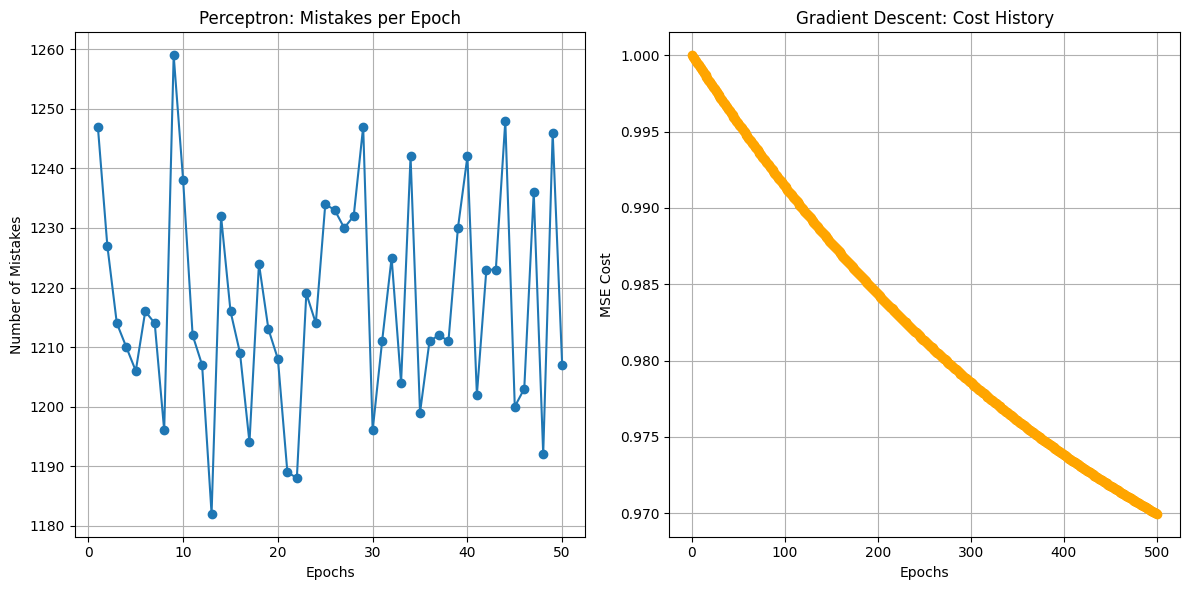

In [32]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(model_p.mistakes) + 1), model_p.mistakes, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of Mistakes')
plt.title('Perceptron: Mistakes per Epoch')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(model_gd.cost_history) + 1), model_gd.cost_history, marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('MSE Cost')
plt.title('Gradient Descent: Cost History')
plt.grid(True)

plt.tight_layout()
plt.show()

In [33]:
from sklearn.metrics import accuracy_score

y_pred_p = model_p.predict(X_test)
accuracy_p = accuracy_score(y_test, y_pred_p)
print(f"Perceptron Test Accuracy: {accuracy_p:.4f}")

y_pred_gd = model_gd.predict(X_test)
accuracy_gd = accuracy_score(y_test, y_pred_gd)
print(f"Gradient Descent Test Accuracy: {accuracy_gd:.4f}")

y_pred_margin = model_margin.predict(X_test)
accuracy_margin = accuracy_score(y_test, y_pred_margin)
print(f"Margin Classifier Test Accuracy: {accuracy_margin:.4f}")

Perceptron Test Accuracy: 0.5015
Gradient Descent Test Accuracy: 0.6280
Margin Classifier Test Accuracy: 0.6280


If a new water sample has chemical levels very close to the decision boundary, you would generally trust the Margin Classifier more than the Perceptron.

  **Perceptron**: The Perceptron algorithm is designed to find any separating hyperplane. If data points are close to the boundary (or if the data is not perfectly linearly separable), the Perceptron can be very sensitive to small changes in these points. Its decision boundary might shift significantly with slight variations, making its predictions near the boundary less reliable and potentially unstable.

  **Margin Classifier's Robustness (Hinge Loss & Regularization)**: The Margin Classifier (similar to an SVM) is specifically designed to create a maximum margin between classes. This margin acts as a safety zone, meaning that samples close to the decision boundary still have some space before being flipped to the other class. The Hinge Loss function, by penalizing only points that violate this margin, encourages a better decision boundary that generalizes better and is less affected by individual noisy points near the boundary. Additionally, L2 Regularization helps prevent overfitting, leading to a smoother and more stable decision boundary. Therefore, for samples near the decision boundary, the Margin Classifier's prediction would be considered more reliable due to its inherent design for robustness and generalization.

# Discussion Questions

### Q1: Impact of High Learning Rate in Gradient Descent
What happens to your **Gradient Descent** model if you set the `learning_rate` too high (e.g., `1.0`)?
*Hint: Think about convergence, overshooting, and divergence.*

---

### Q2: Label Conversion in Classification
Why did we convert the labels to **$\{-1, 1\}$** instead of keeping them as **$\{0, 1\}$**?
*Hint: Consider the mathematical formulation of the loss function (e.g., Hinge Loss) and symmetry.*

---

### Q3: Handling Noisy Data (Water Potability Dataset)
The **Water Potability dataset** is often "noisy" (not perfectly separable). Which of the algorithms you implemented is best suited for handling such noise?
*Hint: Think about robustness to outliers and margin-based classifiers.*


**Answers**

1. If you set the learning rate too high in Gradient Descent, the model will likely overshoot the minima. Instead of converging, the weights and bias might not settle, causing the loss to increase rather than decrease. This leads to an unstable training process and a non-convergent model.

2. We convert labels to $\{-1, 1\}$ instead of keeping them as $\{0, 1\}$primarily for mathematical convenience and consistency with certain linear classifier formulations, especially those involving margins (like Perceptron and SVM with Hinge Loss). When the target variable $y_i$ is $\{-1, 1\}$, the product $y_i(w^T x_i + b)$ directly indicates whether a classification is correct and by how much it satisfies a margin. For example, in Hinge Loss, we want $y_i(w^T x_i + b) \ge 1$ for correct classification. If $y_i$ were $0$ or $1$, the mathematical interpretation of such conditions and the symmetry around the decision boundary would be less straightforward.

3. For a noisy dataset like the Water Potability dataset, the Margin Classifier (SVM-like with Hinge Loss and L2 Regularization) is best suited.

    The Perceptron is highly sensitive to noise and non-linearly separable data. It will oscillate indefinitely if the data is not perfectly separable, constantly trying to correct misclassifications.


    Gradient Descent with MSE is more robust than Perceptron but still aims to minimize the square of errors, which can be heavily influenced by outliers (noisy points).

    The Margin Classifier (specifically with Hinge Loss) is designed to be robust to noise. The Hinge Loss only penalizes points that are misclassified and within the margin, or that violate the margin condition. It ignores correctly classified points that are outside the margin. This means it focuses on the 'hardest' examples and is less affected by outliers far from the decision boundary.
    
    Additionally, L2 Regularization further helps by preventing overfitting and promoting a smoother decision boundary, which is beneficial in noisy environments.